# Cortical network model

Analysis of 3-population cortical network model with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal modules
from logger import logger
from network_model import *
from utils import *
from fileops import get_data_root, get_output_equivalent, load_lineagg_data, save_figs_book
from constants import *
from batchutils import *
from plotters import plot_table, harmonize_axes_limits
from postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor
from model_params import *

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_output_equivalent(get_data_root(), 'raw', 'model')

### Input data parameters

 2024/04/16 18:47:48: assembling batch analysis settings...


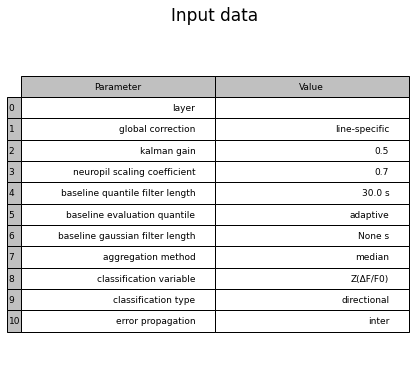

In [3]:
# Parameters determining location of reference activity profiles
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

# Get data input directory
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Plot dataset info table
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Input data', aspect=1.5)

### Load data and compute raw response profiles

 2024/04/16 18:47:52: loading line-average data (with inter-propagated SE)
 2024/04/16 18:47:52: loading line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/16 18:47:52: loading sst data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/16 18:47:52: loading pv data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main folder
 2024/04/16 18:47:52: loading sarah_line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V

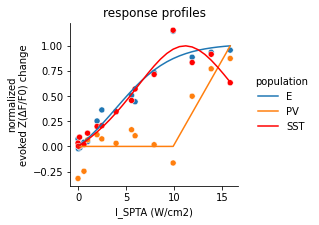

In [4]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles')

# Save response profiles to file (if not already saved)
ref_profiles = resp_profiles.unstack('population')
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values

## Literature review

 2024/04/16 18:47:55: initialized NetworkModel(E, PV, SST)
 2024/04/16 18:47:55: initialized NetworkModel(E, PV, SST)
 2024/04/16 18:47:55: initialized NetworkModel(E, PV, SST)
 2024/04/16 18:47:55: initialized NetworkModel(E, PV, SST)


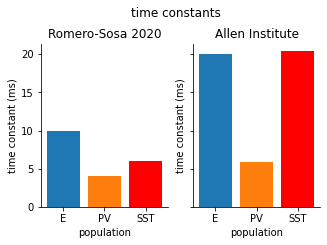

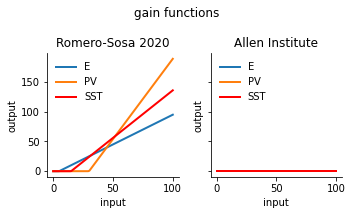

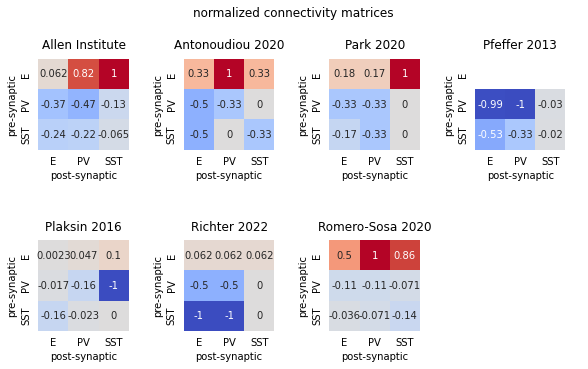

In [5]:
# Firing rate adaptation time constants 
figs['litreview tau'], axes = plt.subplots(
    1, len(tau_dict), figsize=(2.5 * len(tau_dict), 3), sharey=True)
figs['litreview tau'].suptitle('time constants', y=1.05)
for ax, (key, t) in zip(axes, tau_dict.items()):
    NetworkModel(tau=t).plot_time_constants(ax=ax)
    ax.set_title(key)

# Gain function parameters
figs['litreview fgains'], axes = plt.subplots(
    1, len(fparams_dict), figsize=(2.5 * len(fparams_dict), 3), sharey=True)
figs['litreview fgains'].suptitle('gain functions')
for ax, (key, fp) in zip(axes, fparams_dict.items()):
    NetworkModel(fparams=fp).plot_fgain(ax=ax)
    ax.set_title(key)

# Connectivity matrices
figs['litreview W'] = NetworkModel.plot_connectivity_matrix(W_dict, norm=True)

## 3-population (E, SST, PV) model

### Define model

 2024/04/16 19:01:34: initialized NetworkModel(E, PV, SST)


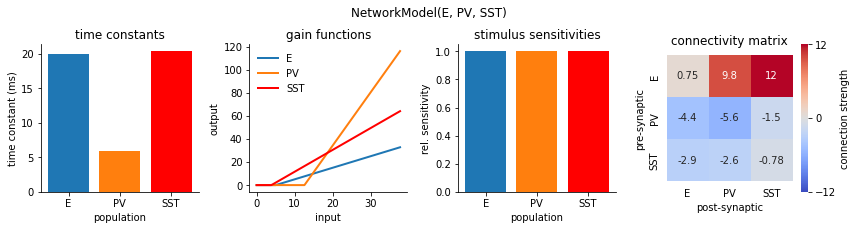

In [13]:
# Relative stimulus sensitivities per population
srel = pd.Series(
    1., 
    index=POPULATIONS,
    name='stimulus sensitivity'
)
# srel.loc['E'] = 2
# srel.loc['PV'] = 2
# srel.loc['SST'] = 0

# Initialize model
source_key = 'Allen Institute'
model = NetworkModel(
    W=NetworkModel.rescale_W(W_dict[source_key]),
    tau=tau_dict[source_key], 
    fparams=NetworkModel.rescale_fparams(fparams_dict[source_key]),
    srel=srel
)

# Plot model summary
figs['model'] = model.plot_summary()    

### Define model evaluation/optimization parameters

In [7]:
norm = True  # whether to normalize activation profiles
disparity_cost_factor = 1e-3 # scaling factor for disparity cost
Wdev_cost_factor = 0.  # scaling factor for network deviation cost
rel_perturbation = 0.1  # relative perturbations for model sensitivity analysis

### Example simulation and stimulus amplitude sweep

 2024/04/16 18:48:06: NetworkModel(E, PV, SST): running 500.0 s long simulation with A = 6.0
 2024/04/16 18:48:06: simulation completed in 0.022 s
 2024/04/16 18:48:06: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 54.69it/s]


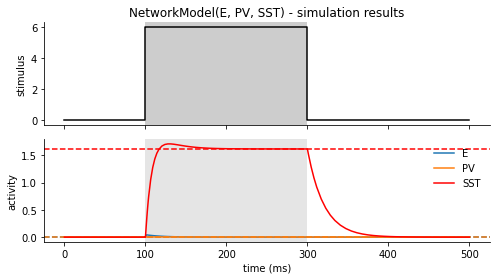

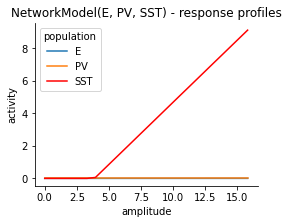

In [8]:
# Define relative amplitudes of external input per population for reference simulations
Athr = model.fparams.loc['E', 'x0']  # E activation threshold
A = 1.2 * Athr

# Simulate model, and extract steady-state stimulus-evoked activity
sol = model.simulate(A=A)
try:
    rss = model.extract_steady_state(sol)
except MetricError as e:
    logger.error(e)
    rss = None

# Plot results
figs['timeseries'] = model.plot_timeseries(sol, ss=rss)

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['ss dep norm.'] = model.plot_sweep_results(
    sweep_rss, title=f'{model} - response profiles')

# # Evaluate sensitivity to network connectivity perturbations
# Wsensitivity = model.evaluate_sensitivity(
#     amps, rel_perturbation=rel_perturbation, norm=norm, 
#     disparity_cost_factor=disparity_cost_factor)
# figs['sensitivity'] = model.plot_connectivity_matrix(
#     W=Wsensitivity, title=f'sensitivity to +/-{rel_perturbation * 1e2:.0f}% perturbation');

### Explore/optimize connectivity parameters

 2024/04/16 19:26:40: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_W2a7450b2a76171bcccb135b368efcf54_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb5635ae1d7fb0116bcf87b1409191dcc_srelbounds0.0-5.0_diffev_norm_xdisp0.001.csv
 2024/04/16 19:26:40: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_W2a7450b2a76171bcccb135b368efcf54_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb5635ae1d7fb0116bcf87b1409191dcc_srelbounds0.0-5.0_diffev_norm_xdisp0.001_rerun1.csv
 2024/04/16 19:26:40: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_W2a7450b2a76171bcccb135b368efcf54_threshold_linear_fparamsd39e3333a72ddb661bc5db06c44d4b9d_tauE20.01PV5.93SST20.36_targetsb5635ae1d7fb0116bcf87b1409191dcc_srelbounds0.0-5.0_diffev_norm_xdisp0.001_rerun2.csv
 2024/04/16 19:26:40: loading optimization results from /gpfs/scratch/lema

100%|██████████| 25/25 [00:00<00:00, 32.49it/s]


 2024/04/16 19:26:43: running stimulation sweep


100%|██████████| 25/25 [00:02<00:00, 10.53it/s]


 2024/04/16 19:26:47: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 33.45it/s]


 2024/04/16 19:26:49: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 31.99it/s]


 2024/04/16 19:26:51: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 33.09it/s]


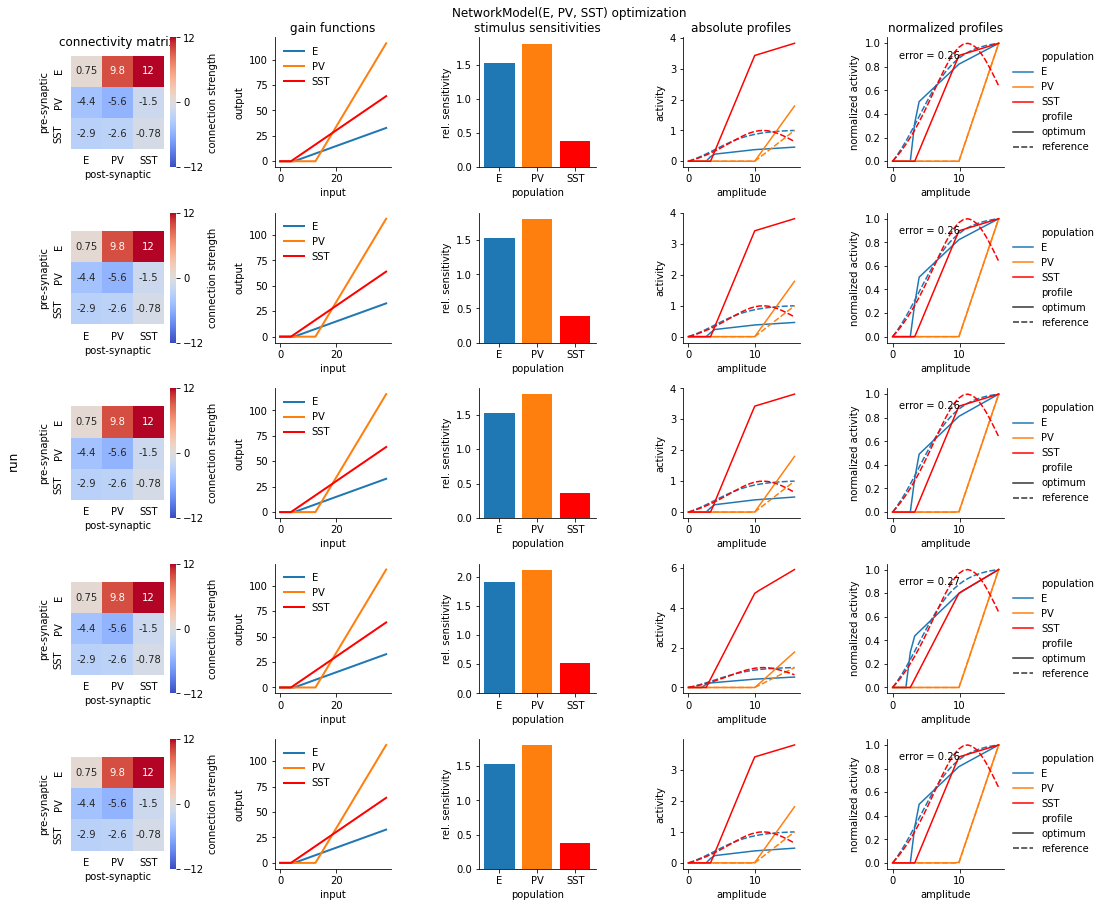

In [35]:
# Adjust gains
# fparams_uniform = model.fparams.copy()
# for k in fparams_uniform.index:
#     fparams_uniform.loc[k] = fparams_uniform.loc['E']
# model.fparams = fparams_uniform

# Constraints on exploration parameters (connectivity matrix and stimulus sensitivity)
# Wbounds = model.get_coupling_bounds()
# Wbounds.loc['SST', 'SST'] = (0, 0)
# Wbounds = model.get_coupling_bounds(wmax=10)
Wbounds = None
# model.srel = None
srel_bounds = (0, 5)
# model.srel = pd.Series(
#     {'E': 1., 'PV': 0.2, 'SST': 1.}, 
#     name='stimulus sensitivity'
# )
# srel_bounds = None

# Define optimization parameters
optargs, optkwargs = (
    [model, ref_profiles],
    dict(
        norm=norm, 
        disparity_cost_factor=disparity_cost_factor,
        Wdev_cost_factor=Wdev_cost_factor,
        logdir=logdir,
        mpi=True,
        Wbounds=Wbounds,
        srel_bounds=srel_bounds,
    )
)

# # Optimize model parameters to minimize divergence with reference profiles
# optres = ModelOptimizer.optimize(*optargs, **optkwargs)

# Load and plot optimization history
histories = ModelOptimizer.load_optimization_history(*optargs, **optkwargs)
if 'run' not in histories.index.names:
    histories = pd.concat({0: histories}, names=['run'])
has_converged = ModelOptimizer.has_optimization_converged(histories)
for irun, converged in has_converged.items():
    if not converged:
        logger.warning(f'optimization did not converge for run {irun}')

# Extract optimum parameters from each run and associated cost
optimums = ModelOptimizer.extract_optimum(histories)

# Plot similarity between connectivity matrices from different runs, if available
if Wbounds is not None:
    Wopts = {k: model.parse_optimum_vector(v)['W'] for k, v in optimums.items()}
    Wopts = pd.concat(Wopts, names=['run'])
    figs['Wopt convergence'] = model.plot_connectivity_matrix(Wopts, agg=True)

# Create figure
figkey = 'opt results'
nruns = len(optimums)
ncols = 5
figs[figkey], axes = plt.subplots(nruns, ncols, figsize=(3 * ncols, 2.5 * nruns))
axes = np.atleast_2d(axes)

# For each run, perform stimulus sweep with optimal connectivity matrix
for irow, (axrow, (irun, optvec)) in enumerate(zip(axes, optimums.groupby('run'))):
    opt = model.parse_optimum_vector(optvec.iloc[0])
    if 'W' in opt:
        model.W = opt['W']
    if 'srel' in opt:
        model.srel = opt['srel']
    
    sweep_data = model.run_stim_sweep(amps)
    sweep_rss = model.extract_steady_state(sweep_data)

    # Compare results to reference profiles
    cost = model.evaluate_stim_sweep(
        ref_profiles, sweep_data, norm=norm, disparity_cost_factor=disparity_cost_factor)
    sweep_comp = pd.concat({
        'optimum': sweep_rss,
        'reference': ref_profiles
    }, axis=0, names=['profile'])

    # Plot results
    axtitle = None if irow == 0 else ''
    model.plot_connectivity_matrix(W=model.W, ax=axrow[0], title=axtitle)
    model.plot_fgain(ax=axrow[1], title=axtitle)
    model.plot_stimulus_sensitivity(ax=axrow[2], title=axtitle)
    for ax, n in zip(axrow[3:], [False, True]):
        model.plot_sweep_results(sweep_comp, norm=n, ax=ax, style='profile')
        if irow == 0:
            ax.set_title(f'{"normalized" if n else "absolute"} profiles')
        if not n:
            ax.get_legend().remove()
        if n == norm:
            ax.text(0.1, 0.9, f'error = {cost:.2f}', transform=ax.transAxes, ha='left', va='top')
    sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

# Harmonize axes limits for absolute profiles
harmonize_axes_limits(axes[:, 1], 'y')

# Adjust layout
figs[figkey].tight_layout()
figs[figkey].supylabel('run', x=-0.02)
figs[figkey].subplots_adjust(wspace=.75)
figs[figkey].suptitle(f'{model} optimization', y=1 + 0.02 / nruns);

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2024/04/12 17:12:03: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.04.12/figs_network_model.pdf:


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
